In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib.image as mpimg
import os
from sqlalchemy import create_engine

In [2]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [4]:
host = os.environ['KB_HOST']
database = os.environ['KB_DATABASE']
user = os.environ['KB_USER']
pw = os.environ['KB_PASSWORD']
port = os.environ['KB_PORT']
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{database}')

In [19]:
oal_cla_n = pd.read_sql("""
                        SELECT COUNT(DISTINCT(dt.doi)) AS n, is_research
                        FROM kb_project_openbib.add_document_types_20240831 AS dt
                        JOIN fiz_openalex_bdb_20240831_openbib.items AS oal
                            ON LOWER(dt.doi) = LOWER(oal.doi)
                        WHERE oal.pubyear BETWEEN 2014 AND 2023
                        GROUP BY is_research
                        """, 
                        con=engine)

In [22]:
oal_cla_n[oal_cla_n['is_research'] == False].n / oal_cla_n.n.sum()

0    0.107489
Name: n, dtype: float64

In [24]:
oal_cla_n[oal_cla_n['is_research'] == False].n

0    4589967
Name: n, dtype: int64

In [23]:
oal_cla_n.n.sum()

42701863

In [8]:
scp_cla_n = pd.read_sql("""
                        SELECT COUNT(DISTINCT(dt.doi)) AS n, is_research
                        FROM kb_project_openbib.classification_article_reviews_2014_2024_august24 AS dt
                        JOIN scp_b_202407.items scp
                            ON LOWER(dt.doi) = LOWER(scp.doi)
                        WHERE ('Article' = ANY(item_type) OR 'Review' = ANY(item_type)) AND (scp.pubyear BETWEEN 2014 AND 2023)
                        GROUP BY is_research
                        """, 
                        con=engine)

In [26]:
scp_cla_n[scp_cla_n['is_research'] == False].n

0    327522
Name: n, dtype: int64

In [25]:
scp_cla_n.n.sum()

22338918

In [9]:
scp_cla_n[scp_cla_n['is_research'] == False].n / scp_cla_n.n.sum()

0    0.014661
Name: n, dtype: float64

In [10]:
oal_n = pd.read_sql("""
                    SELECT COUNT(DISTINCT(oal.doi)) AS n, oal.pubyear 
                    FROM fiz_openalex_bdb_20240831_openbib.items AS oal
                    JOIN scp_b_202407.items AS scp
                        ON LOWER(oal.doi) = LOWER(scp.doi)
                    WHERE oal.pubyear BETWEEN 2014 AND 2023 AND oal.source_type = 'journal'
                        AND ('article' = ANY(oal.item_type) OR 'review' = ANY(oal.item_type))
                    GROUP BY oal.pubyear 
                    """, 
                    con=engine)

In [11]:
scp_n = pd.read_sql("""
                    SELECT COUNT(DISTINCT(oal.doi)) AS n, oal.pubyear 
                    FROM fiz_openalex_bdb_20240831_openbib.items AS oal
                    JOIN scp_b_202407.items AS scp
                        ON LOWER(oal.doi) = LOWER(scp.doi)
                    WHERE oal.pubyear BETWEEN 2014 AND 2023 AND oal.source_type = 'journal'
                        AND ('Article' = ANY(scp.item_type) OR 'Review' = ANY(scp.item_type))
                    GROUP BY oal.pubyear 
                    """, 
                    con=engine)

In [12]:
dt_n = pd.read_sql("""
                   SELECT COUNT(DISTINCT(dt.doi)) AS n, oal.pubyear 
                   FROM kb_project_openbib.classification_article_reviews_2014_2024_august24 AS dt
                   JOIN scp_b_202407.items AS scp
                       ON LOWER(dt.doi) = LOWER(scp.doi)
                   JOIN fiz_openalex_bdb_20240831_openbib.items AS oal 
                       ON LOWER(dt.doi) = LOWER(oal.doi)
                   WHERE oal.pubyear BETWEEN 2014 AND 2023 AND oal.source_type = 'journal'
                       AND is_research=True AND oal.source_type = 'journal' 
                   GROUP BY oal.pubyear 
                   """, 
                   con=engine)

In [13]:
all_n = pd.read_sql("""
                   SELECT COUNT(DISTINCT(oal.doi)) AS n
                   FROM fiz_openalex_bdb_20240831_openbib.items AS oal 
                   JOIN scp_b_202407.items AS scp
                       ON LOWER(oal.doi) = LOWER(scp.doi)
                   WHERE oal.pubyear BETWEEN 2014 AND 2023 AND oal.source_type = 'journal'
                   """, 
                   con=engine)

In [14]:
oal_n.n.sum() / all_n.n.sum()

0.9586868104541294

In [15]:
scp_n.n.sum() / all_n.n.sum()

0.88919106503258

In [16]:
dt_n.n.sum() / all_n.n.sum()

0.9318841104461512

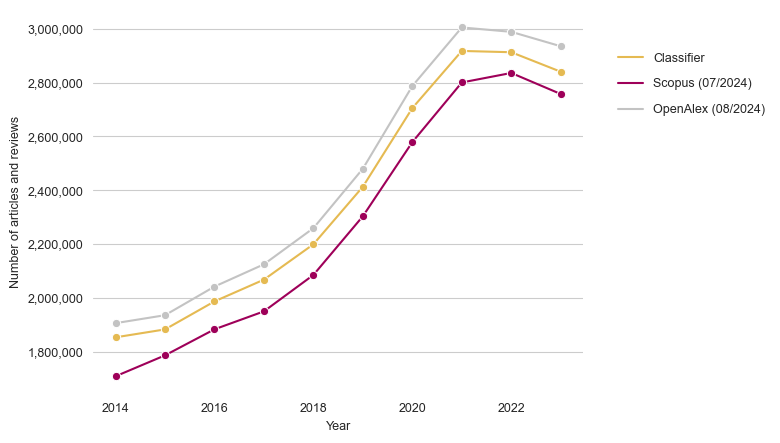

In [21]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=oal_n,
             x='pubyear',
             y='n',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=scp_n,
             x='pubyear',
             y='n',
             color='#9e0059',
             marker='o',
             ax=ax)

sns.lineplot(data=dt_n,
             x='pubyear',
             y='n',
             color='#E5BA52',
             marker='o',
             ax=ax)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.grid(False, which='both', axis='x')
ax.set(xlabel='Year', ylabel='Number of articles and reviews')

clas_patch = Line2D([0], [0], color='#E5BA52', label='Classifier')
scp_patch = Line2D([0], [0], color='#9e0059', label='Scopus (07/2024)')
oal_patch = Line2D([0], [0], color='#c3c3c3', label='OpenAlex (08/2024)')

lgd = fig.legend(handles=[clas_patch, scp_patch, oal_patch], frameon=False,
                 bbox_to_anchor=(1.3, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/oal_scp_comparison_paper.png', format='png', bbox_inches='tight', dpi=500)

In [27]:
oal_n.n.sum()

24465047

In [28]:
scp_n.n.sum()

22691562

In [29]:
dt_n.n.sum()

23781060

In [30]:
all_n.n.sum()

25519332

In [5]:
oal_topic = pd.read_sql("""
                        SELECT COUNT(DISTINCT(oal.doi)) AS n, domains.display_name AS topic, is_research
                        FROM fiz_openalex_rep_20240831_openbib.works AS oal
                        LEFT JOIN fiz_openalex_rep_20240831_openbib.topics AS topics
                            ON oal.primary_topic = topics.id
                        LEFT JOIN fiz_openalex_rep_20240831_openbib.domains AS domains
                            ON topics.domain_id = domains.id
                        JOIN kb_project_openbib.add_document_types_20240831 AS dt
                            ON LOWER(TRIM('https://doi.org/' from oal.doi)) = LOWER(dt.doi)
                        WHERE oal.publication_year BETWEEN 2014 AND 2023
                        GROUP BY domains.display_name, is_research
                        """, 
                        con=engine)

In [6]:
oal_topic = oal_topic.fillna(value='No topic assigned')

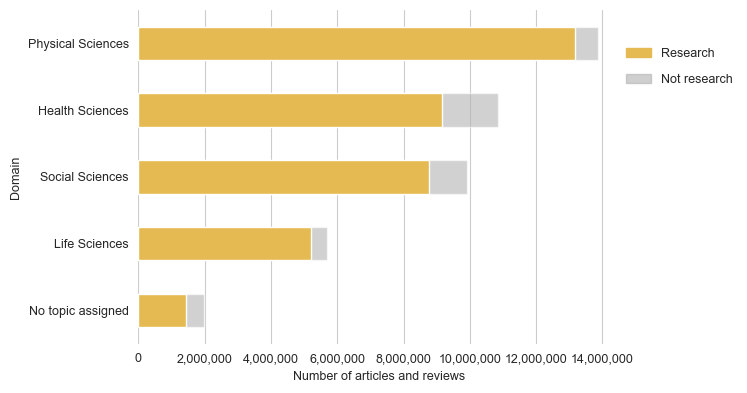

In [7]:
fig, ax = plt.subplots(figsize=(6.5,4))
plt.box(False)

sns.barplot(data=oal_topic.groupby(['topic'])['n'].sum().reset_index(), 
            x='n', 
            y='topic', 
            alpha=0.6,
            color='#b3b3b3a0',
            order=['Physical Sciences', 'Health Sciences', 'Social Sciences', 'Life Sciences', 'No topic assigned'],
            width=0.5,
            saturation=1,
            errorbar=None)

sns.barplot(data=oal_topic[oal_topic.is_research == True], 
            x='n', 
            y='topic', 
            alpha=1,
            color='#E5BA52',
            order=['Physical Sciences', 'Health Sciences', 'Social Sciences', 'Life Sciences', 'No topic assigned'],
            width=0.5,
            saturation=1,
            errorbar=None)

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='Number of articles and reviews', ylabel='Domain')

research_patch = mpatches.Patch(color='#E5BA52', label='Research')
not_research_patch = mpatches.Patch(color='#b3b3b3a0', label='Not research')

lgd = fig.legend(handles=[research_patch, not_research_patch], frameon=False,
                 bbox_to_anchor=(1.15, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/dt_topics_paper.png', format='png', bbox_inches='tight', dpi=500)

In [8]:
oal_topic

,n,topic,is_research
0,1687870,Health Sciences,False
1,9161300,Health Sciences,True
2,492378,Life Sciences,False
3,5197915,Life Sciences,True
4,680268,Physical Sciences,False
5,13175388,Physical Sciences,True
6,1129460,Social Sciences,False
7,8775274,Social Sciences,True
8,530817,No topic assigned,False
9,1439399,No topic assigned,True


In [9]:
oal_topic.n.sum()

42270069

In [12]:
oal_institutions = pd.read_sql("""
                        SELECT oal_institutions.type, is_research, COUNT(DISTINCT(oal.doi)) AS n
                        FROM (
                        	SELECT dt.doi, dt.is_research, JSON_ARRAY_ELEMENTS_TEXT(corresponding_institution_ids) AS institution_id
                        	FROM fiz_openalex_rep_20240831_openbib.works AS oal
                        	JOIN kb_project_openbib.add_document_types_20240831 AS dt
                        		ON LOWER(TRIM('https://doi.org/' FROM oal.doi)) = dt.doi
                        ) AS oal
                        JOIN fiz_openalex_rep_20240831_openbib.institutions AS oal_institutions
                        	ON TRIM('https://openalex.org/' FROM oal.institution_id) = oal_institutions.id
                        GROUP BY oal_institutions.type, is_research
                        """, 
                        con=engine)

In [13]:
oal_institutions

,type,is_research,n
0,archive,False,6577
1,archive,True,73000
2,company,False,33612
3,company,True,372109
4,education,False,776652
5,education,True,14868221
6,facility,False,77446
7,facility,True,1963531
8,government,False,51733
9,government,True,1068735


In [27]:
oal_institutions_all = oal_institutions.groupby(['type'])['n'].sum().reset_index()
oal_institutions_all.rename(columns={'n': 'all_n'}, inplace=True)

In [30]:
oal_institutions_plot = pd.merge(oal_institutions, oal_institutions_all, on='type')
oal_institutions_plot['prop'] = oal_institutions_plot.n / oal_institutions_plot.all_n

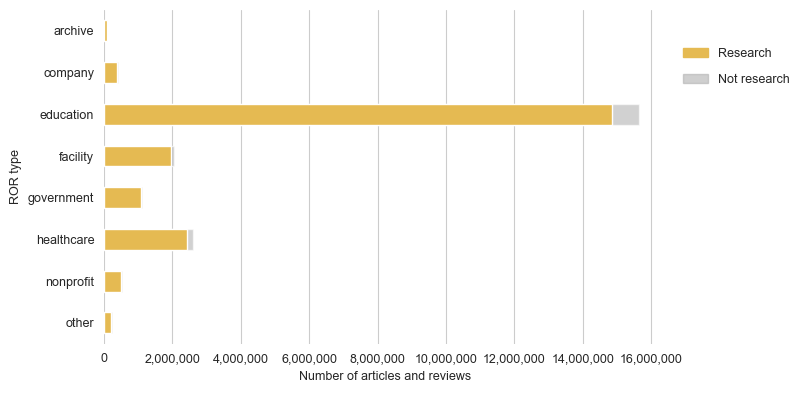

In [39]:
fig, ax = plt.subplots(figsize=(7,4))
plt.box(False)

sns.barplot(data=oal_institutions.groupby(['type'])['n'].sum().reset_index(), 
            x='n', 
            y='type', 
            alpha=0.6,
            color='#b3b3b3a0',
            order=['archive', 'company', 'education', 'facility', 'government', 'healthcare', 'nonprofit', 'other'],
            width=0.5,
            saturation=1,
            errorbar=None)

sns.barplot(data=oal_institutions[oal_institutions.is_research == True], 
            x='n', 
            y='type', 
            alpha=1,
            color='#E5BA52',
            order=['archive', 'company', 'education', 'facility', 'government', 'healthcare', 'nonprofit', 'other'],
            width=0.5,
            saturation=1,
            errorbar=None)

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='Number of articles and reviews', ylabel='ROR type')

research_patch = mpatches.Patch(color='#E5BA52', label='Research')
not_research_patch = mpatches.Patch(color='#b3b3b3a0', label='Not research')

lgd = fig.legend(handles=[research_patch, not_research_patch], frameon=False,
                 bbox_to_anchor=(1.15, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/institutions_paper.png', format='png', bbox_inches='tight', dpi=500)

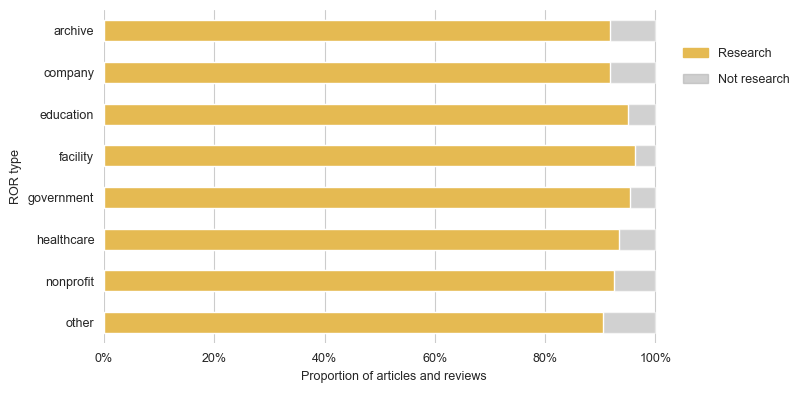

In [43]:
fig, ax = plt.subplots(figsize=(7,4))
plt.box(False)

sns.barplot(data=oal_institutions, 
            x=[1] * len(oal_institutions_plot), 
            y='type', 
            alpha=0.6,
            color='#b3b3b3a0',
            order=['archive', 'company', 'education', 'facility', 'government', 'healthcare', 'nonprofit', 'other'],
            width=0.5,
            saturation=1,
            errorbar=None)

sns.barplot(data=oal_institutions_plot[oal_institutions_plot.is_research == True], 
            x='prop', 
            y='type', 
            alpha=1,
            color='#E5BA52',
            order=['archive', 'company', 'education', 'facility', 'government', 'healthcare', 'nonprofit', 'other'],
            width=0.5,
            saturation=1,
            errorbar=None)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.set(xlabel='Proportion of articles and reviews', ylabel='ROR type')

research_patch = mpatches.Patch(color='#E5BA52', label='Research')
not_research_patch = mpatches.Patch(color='#b3b3b3a0', label='Not research')

lgd = fig.legend(handles=[research_patch, not_research_patch], frameon=False,
                 bbox_to_anchor=(1.15, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/institutions_prop_paper.png', format='png', bbox_inches='tight', dpi=500)

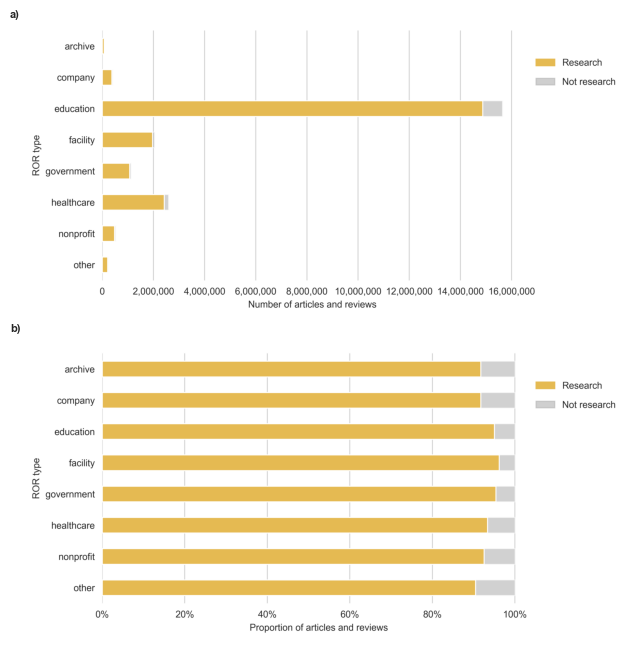

In [64]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
filelist =  ['institutions_paper', 'institutions_prop_paper']
for i, (ax, file) in enumerate(zip(axs.flat, filelist)):
    ax.set_axis_off()
    filename = 'media/' + file + '.png'
    ax.imshow(mpimg.imread(filename), extent=None)
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.text(-100, -2200, 'a)', size=8, weight='bold')
plt.text(-100, -100, 'b)', size=8, weight='bold')
plt.show()
fig.savefig('media/institutions_paper_combined.png', format='png', bbox_inches='tight', dpi=500)

In [65]:
oal_institutions_plot

,type,is_research,n,all_n,prop
0,archive,False,6577,79577,0.082650
1,archive,True,73000,79577,0.917350
2,company,False,33612,405721,0.082845
3,company,True,372109,405721,0.917155
4,education,False,776652,15644873,0.049643
5,education,True,14868221,15644873,0.950357
6,facility,False,77446,2040977,0.037946
7,facility,True,1963531,2040977,0.962054
8,government,False,51733,1120468,0.046171
9,government,True,1068735,1120468,0.953829


In [6]:
oal_types = pd.read_sql("""
                        SELECT COUNT(DISTINCT(oal.doi)) AS n, oal.type
                        FROM fiz_openalex_rep_20240831_openbib.works AS oal
                        JOIN fiz_openalex_rep_20240831_openbib.works_primary_locations AS pl
                            ON LOWER(oal.id) = LOWER(pl.work_id)
                        JOIN fiz_openalex_rep_20240831_openbib.sources AS s
                            ON LOWER(pl.source_id) = LOWER(s.id)
                        WHERE oal.publication_year BETWEEN 2014 AND 2023 AND s.type = 'journal'
                        GROUP BY oal.type
                        """, 
                        con=engine)

In [7]:
oal_types

,n,type
0,40949987,article
1,14668,book
2,28672,book-chapter
3,87000,dataset
4,596,dissertation
5,267800,editorial
6,186234,erratum
7,615810,letter
8,0,libguides
9,171520,other


In [8]:
oal_types.n.sum()

45470084

In [11]:
oal_types[oal_types.type=='article'].n

0    40949987
Name: n, dtype: int64

In [12]:
oal_types[oal_types.type=='review'].n

15    1748196
Name: n, dtype: int64

In [14]:
(40949987 + 1748196) / 45470084

0.9390390173899833

In [5]:
oal_s_types = pd.read_sql("""
                        SELECT COUNT(DISTINCT(oal.doi)) AS n
                        FROM fiz_openalex_rep_20240831_openbib.works AS oal
                        LEFT JOIN fiz_openalex_rep_20240831_openbib.works_primary_locations AS pl
                            ON LOWER(oal.id) = LOWER(pl.work_id)
                        WHERE oal.publication_year BETWEEN 2014 AND 2023 AND pl.source_id IS NULL
                        """, 
                        con=engine)

In [6]:
oal_s_types

,n
0,8445541


In [ ]:
oal_filter = pd.read_sql("""
                        SELECT COUNT(DISTINCT(oal.doi)) AS n
                        FROM kb_project_openbib.add_document_types_20240831 AS dt
                        JOIN fiz_openalex_bdb_20240831_openbib.items AS oal
                            ON LOWER(oal.doi) = LOWER(dt.doi)
                        JOIN fiz_openalex_rep_20240831_openbib.works_biblio AS biblio
                        	ON LOWER(biblio.work_id) = LOWER(dt.openalex_id)
                        WHERE LOWER(biblio.issue) LIKE '%%sup%%' OR LOWER(biblio.issue) LIKE '%%meet%%' 
                            AND oal.pubyear BETWEEN 2014 AND 2023
                        """, 
                        con=engine)

In [ ]:
oal_filter

In [3]:
from google.cloud import bigquery

client = bigquery.Client(project='subugoe-collaborative')

oal_filter = client.query(f"""
                           SELECT COUNT(DISTINCT(doi)) AS n
                           FROM subugoe-collaborative.resources.oal_biblio_august24
                           WHERE LOWER(biblio.issue) LIKE '%sup%' OR LOWER(biblio.issue) LIKE '%meet%'
                               AND publication_year BETWEEN 2014 AND 2023
                           """).to_dataframe()

In [4]:
oal_filter

,n
0,803688


In [5]:
803688 / 42702315

0.01882071264754616